# Importing libraries

In [28]:
import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue as prologue

In [29]:
import matplotlib.pyplot as plt

# Loading data and standerdize Data

In [30]:
def data_loading_standerdize(n_samples):
    #Data loading
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)
    #Standarization of the training set
    mu,std = train_input.mean(), train_input.std()
    train_input.sub_(mu).div_(std)
    #Standarization of the testing set
    mu,std = test_input.mean(), test_input.std()
    test_input.sub_(mu).div_(std)
    return train_input, train_target, train_classes, test_input, test_target, test_classes

In [31]:
train_input, train_target, train_classes, test_input, test_target, test_classes = data_loading_standerdize(1000)

In [32]:
train_input[:,0,:].view(-1,1,14,14).shape

torch.Size([1000, 1, 14, 14])

In [46]:
class LeNet(nn.Module):
    def __init__(self, weight_sharing = False):
        super(LeNet, self).__init__()
        
        #Image1_input
        self.conv1_0 = nn.Conv2d(1, 6, kernel_size=3)   # (14 => 12) + maxpool => 6
        self.conv2_0 = nn.Conv2d(6, 16, kernel_size=3)  # (6 => 4) + maxpool => 2
        self.conv3_0 = nn.Conv2d(16, 120, kernel_size=2) # (2 => 1)
        self.fc1_0 = nn.Linear(120, 84)
        self.fc2_0 = nn.Linear(84, 10)
        
        # Image2_input
        
        self.conv1_1 = nn.Conv2d(1, 6, kernel_size=3) 
        self.conv2_1 = nn.Conv2d(6, 16, kernel_size=3)
        self.conv3_1 = nn.Conv2d(16, 120, kernel_size=2) 
        self.fc1_1 = nn.Linear(120, 84)
        self.fc2_1 = nn.Linear(84, 10)
        
        # Comparison
        self.fc3 = nn.Linear(20, 2)
        self.weight_sharing = weight_sharing 
        
    def forward(self, x ):
        
        input_1 = x[:,0,:].view(-1,1,14,14) # Selecting first image
        input_2 = x[:,1,:].view(-1,1,14,14) # Selectind second image
        
        
        input_1 = F.tanh(self.conv1_0(input_1)) # 1st Convolution Layer
        input_1 = F.tanh(F.avg_pool2d(input_1, kernel_size=2, stride=2)) # 1st Averaging with max pool
        input_1 = F.tanh(self.conv2_0(input_1)) # 2nd Convolution Layer
        input_1 = F.tanh(F.avg_pool2d(input_1, kernel_size=2, stride=2)) # 2nd Averaging with max pool
        input_1 = F.tanh(self.conv3_0(input_1)) # 3nd Convolution Layer
        
        input_1 = F.tanh(self.fc1_0(input_1.view(-1,120)))
        input_1 = self.fc2_0(input_1)
        
        
        if self.weight_sharing :
            
            input_2 = F.tanh(self.conv1_0(input_2)) # 1st Convolution Layer
            input_2 = F.tanh(F.avg_pool2d(input_2, kernel_size=2, stride=2)) # 1st Averaging with max pool
            input_2 = F.tanh(self.conv2_0(input_2)) # 2nd Convolution Layer
            input_2 = F.tanh(F.avg_pool2d(input_2, kernel_size=2, stride=2)) # 2nd Averaging with max pool
            input_2 = F.tanh(self.conv3_0(input_2)) # 3nd Convolution Layer

            input_2 = F.tanh(self.fc1_0(input_2.view(-1,120)))
            input_2 = self.fc2_0(input_2)
            
        else:
            
            input_2 = F.tanh(self.conv1_1(input_2)) # 1st Convolution Layer
            input_2 = F.tanh(F.avg_pool2d(input_2, kernel_size=2, stride=2)) # 1st Averaging with max pool
            input_2 = F.tanh(self.conv2_1(input_2)) # 2nd Convolution Layer
            input_2 = F.tanh(F.avg_pool2d(input_2, kernel_size=2, stride=2)) # 2nd Averaging with max pool
            input_2 = F.tanh(self.conv3_1(input_2)) # 3nd Convolution Layer

            input_2 = F.tanh(self.fc1_1(input_2.view(-1,120)))
            input_2 = self.fc2_1(input_2)
        
        
        #Comparison layer
        concat = torch.cat((input_1,input_2),1)
        x = self.fc3(concat)
        
        return input_1,input_2,x

In [51]:
def train_LeNet_model(train_input,train_target,train_classes, test_input,test_target,test_classes,
                      batch_size = 100, n_epochs = 25, lr = 0.1, weight_sharing = False, auxilary_loss = False,
                      verbose = False):
    
    model = LeNet(weight_sharing)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr = lr)
    error = []
    train_error = []
    test_error = []
    
    for e in range(0,n_epochs):
        
        train_data = zip(train_input.split(batch_size),
                         train_target.split(batch_size),
                         train_classes.split(batch_size))
        
        test_data = zip(test_input.split(batch_size),
                        test_target.split(batch_size),
                        test_classes.split(batch_size))
        
        for inputs, targets, classes in train_data:
            output = model(inputs)
            loss_1 = criterion(output[0],classes[:,0])
            loss_2 = criterion(output[1],classes[:,1])
            main_loss = criterion(output[2],targets)
            
            # Select loss 
            if auxilary_loss:
                loss = main_loss + 0.8*loss_1 + 0.8*loss_2
            else:
                loss = main_loss
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        error.append(loss.item())
        
        train_data = zip(train_input.split(batch_size),
                         train_target.split(batch_size),
                         train_classes.split(batch_size))   
        
        train_error.append(compute_errors(model,train_data,train_input.size(0)))
        test_error.append(compute_errors(model,test_data,test_input.size(0)))
        
        if(e%5 ==0) and verbose:
            print('epoch : ',e,' loss : ',loss.item())
        
               
    return model, error, train_error, test_error

In [52]:
def compute_errors(model,data,n_samples):
    nb_errors = 0
    for input_,targets, _ in data:
        output = model(input_)
        _,predicted_classes = torch.max(output[2],1)
        for i in range(0,output[2].size(0)):
            if(predicted_classes[i]!=targets[i]):
                nb_errors = nb_errors+1
    return (nb_errors/n_samples) * 100

Weight Sharing = 'False', Auxilary Loss = 'False'
epoch :  0  loss :  0.6866626143455505
epoch :  5  loss :  0.6806073784828186
epoch :  10  loss :  0.6759340763092041
epoch :  15  loss :  0.6673336625099182
epoch :  20  loss :  0.6456749439239502
epoch :  25  loss :  0.5916059613227844
epoch :  30  loss :  0.5376757979393005
epoch :  35  loss :  0.5089303851127625
epoch :  40  loss :  0.48762208223342896
epoch :  45  loss :  0.470724880695343
epoch :  50  loss :  0.4586281180381775
epoch :  55  loss :  0.4469121992588043
epoch :  60  loss :  0.43512412905693054
epoch :  65  loss :  0.42308878898620605
epoch :  70  loss :  0.4108472466468811
epoch :  75  loss :  0.3986119329929352
epoch :  80  loss :  0.38663139939308167
epoch :  85  loss :  0.375060111284256
epoch :  90  loss :  0.36392903327941895
epoch :  95  loss :  0.3532060980796814
Weight Sharing = 'False', Auxilary Loss = 'True'
epoch :  0  loss :  4.362227916717529
epoch :  5  loss :  4.298736095428467
epoch :  10  loss :  4.0

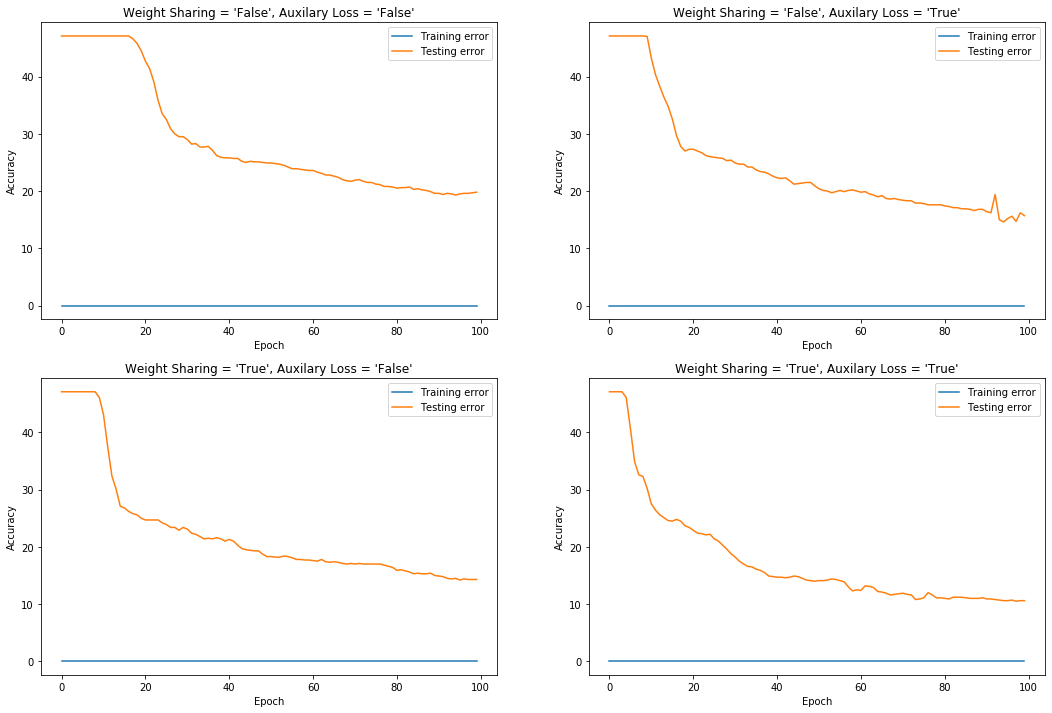

In [54]:
weight_sharing = [False,True]
auxiliary_loss = [False,True]

fig, axes = plt.subplots(2,2, figsize=(18, 12))
for i,weight in enumerate(weight_sharing):
    for j,aux in enumerate(auxiliary_loss):
        
        print("Weight Sharing = '{0}', Auxilary Loss = '{1}'".format(weight,aux))
        
        model,error,train_error,test_error = train_LeNet_model(train_input,train_target,train_classes,
                                                       test_input,test_target,test_classes,
                                                       weight_sharing = weight, 
                                                       auxilary_loss = aux,
                                                       n_epochs = 100, verbose = True)
        
        axes[i,j].plot(train_error, label='Training error')
        axes[i,j].plot(test_error, label='Testing error')
        axes[i,j].set_xlabel("Epoch")
        axes[i,j].set_ylabel("Accuracy")
        axes[i,j].legend(loc='upper right')
        axes[i,j].set_title("Weight Sharing = '{0}', Auxilary Loss = '{1}'".format(weight,aux))

In [ ]:
a = []